## Flight Delay Forecasting
### Dalang, Felix Sihitshuwam

- Preprocess
- Visualize
- Split

In [1]:
import pandas as pd
import numpy as np
import sklearn

from scipy import stats
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('../data/flight_delay.csv')

In [3]:
data.describe()

,Delay
count,675513.000000
mean,9.912939
std,44.895875
min,0.000000
25%,0.000000
50%,0.000000
75%,5.000000
max,1436.000000


In [4]:
data.head(2)

,Depature Airport,Scheduled depature time,Destination Airport,Scheduled arrival time,Delay
0,SVO,2015-10-27 07:40:00,HAV,2015-10-27 20:45:00,0.0
1,SVO,2015-10-27 09:50:00,JFK,2015-10-27 20:35:00,2.0


In [5]:
data.tail(2)

,Depature Airport,Scheduled depature time,Destination Airport,Scheduled arrival time,Delay
675511,SVO,2018-08-31 23:55:00,TSE,2018-09-01 03:15:00,0.0
675512,SVO,2018-08-31 17:25:00,IKT,2018-08-31 23:05:00,379.0


In [6]:
x = data.drop('Delay', axis=1)
y = data['Delay']

In [7]:
types = x.dtypes
print("Number of categorical features:", sum(types=='object'))

Number of categorical features: 4


#### We will now encode the data since they all aren't numeric

In [8]:
le = LabelEncoder()

In [9]:
dept = x['Scheduled depature time']
departure = pd.to_datetime(dept)
arrival = pd.to_datetime(x['Scheduled arrival time'])

duration = departure - arrival
set_ = duration.unique()
le.fit(set_)
duration = le.transform(duration)

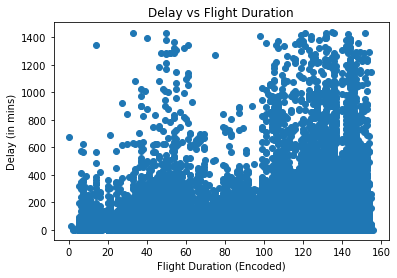

In [10]:
plt.scatter(duration, y)
plt.title('Delay vs Flight Duration')
plt.xlabel('Flight Duration (Encoded)')
plt.ylabel('Delay (in mins)')
plt.show()

#### Detect if there are outliers
##### From the graph it appears there are outliers, but we'll now confirm it.
##### We sample one month of data, (Nov, 2015, here, random choice), then we apply the zcore technique of finding outliers.

In [11]:
sample = data.loc[(data['Scheduled depature time'] > '2015-10-31 23:59:00') &
            (data['Scheduled depature time'] < '2015-12-01 00:00:00')]

# we now have to encode sample data too
for i in sample.columns.values:
    fitter = sample[i]
    sample[i] = le.fit_transform(fitter)

C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [12]:
z = np.abs(stats.zscore(sample))

from [here](https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba) we see that a threshold of 3 is usually used to detect outliers

In [13]:
threshold = 3
print(len(np.where(z > threshold)[0]))

336


This indicates that there are outliers particularly in the 4th (arrival time) column.

Machine Learning Algorithms

In [14]:
train_data = data.loc[data['Scheduled depature time'] < '2018-01-01 00:00:00']
test_data = data.loc[data['Scheduled depature time'] > '2017-12-31 23:59:59']

We will now remove all outliers from the data

In [15]:
for i in data.columns.values:
    fitter = train_data[i].append(test_data[i])
    le.fit(fitter)
    train_data[i] = le.transform(train_data[i])
    test_data[i] = le.transform(test_data[i])

C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Public\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [16]:
z_train = np.abs(stats.zscore(train_data))
train_data_n = train_data[(z_train < 3).all(axis=1)]

z_test = np.abs(stats.zscore(test_data))
test_data_n = test_data[(z_test < 3).all(axis=1)]

train_data.shape[0] - train_data_n.shape[0], test_data.shape[0] - test_data_n.shape[0],

(6370, 1957)

The count of cells above were removed from the train and test data, respectively

In [ ]:
regressor = LinearRegression()
regressor.fit(train_X, train_y)
y_pred = regressor.predict(test_X)

In [ ]:
print('Mean Absolute Error:', metrics.mean_absolute_error(test_y, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(test_y, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y, y_pred)))

The above shows a high error

In [ ]:
from sklearn.preprocessing import MinMaxScaler

min_max = MinMaxScaler()

x_train_m = min_max.fit_transform(train_X)
x_test_m = min_max.fit_transform(test_X)

regressor.fit(x_train_m, train_y)

pred = regressor.predict(x_test_m)

print('Mean Absolute Error:', metrics.mean_absolute_error(test_y, pred))
print('Mean Squared Error:', metrics.mean_squared_error(test_y, pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test_y, pred)))

#### We will now try a polynomial regression using  flight duration as predictor

We join the arrival and departure times into one column in order to concatenate them. For encoding purposes

In [ ]:
dept = pd.Series(x['Scheduled depature time'].unique())
arr = pd.Series(x['Scheduled arrival time'].unique())
all_ = pd.concat([dept, arr], ignore_index=True)
all_ = all_.unique()
dept.shape, arr.shape, all_.shape

We will simply do this on the x_train and test data above

In [ ]:
flight_duration_test = test_X['Scheduled depature time'] - test_X['Scheduled arrival time']
flight_duration_train = train_X['Scheduled depature time'] - train_X['Scheduled arrival time']

flight_duration = pd.concat([flight_duration_train, flight_duration_test])
flight_delay = pd.concat([train_y, test_y])

# type(flight_duration_test), type(flight_duration_train)

In [ ]:
plt.scatter(flight_duration, flight_delay)
plt.title('Delay vs Flight Duration')
plt.xlabel('Flight Duration (Encoded)')
plt.ylabel('Delay (in mins)')
plt.show()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score

In [ ]:
plt.figure(figsize=(18, 6))
degrees = [1, 5, 8]

for i in range(3):
    ax = plt.subplot(1, 3, i+1)
    plt.setp(ax, xticks=(), yticks=())
    
    polynomial_features = PolynomialFeatures(degree=degrees[i])
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                        ("linear_regression", linear_regression)])
    x = flight_duration_train
    x = x[:, np.newaxis]
    y = train_y
    
    pipeline.fit(x, y)
    
    scores = cross_val_score(pipeline, x, y, scoring='neg_mean_squared_error', cv=10)
    
    plt.plot(flight_duration_test, pipeline.predict(flight_duration_test[:, np.newaxis]), label='Model')
    plt.plot(flight_duration_test, test_y, label="True function")
    plt.scatter(x, y, edgecolors='b', s=20, label='Samples')
    plt.xlabel("Flight Duration")
    plt.ylabel("Delay (in mins)")
    
    plt.legend(loc="best")
    
    plt.title(f"Degree {i}\nMSE = {-scores.mean()}")
plt.show()    

#### Logistic Regression

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

lasso = Lasso()
lasso.fit(train_X, train_y)

pred_y = lasso.predict(test_X)

mean_squared_error(test_y, pred_y)

In [ ]:
alphas = [3.2, 3.1, 3]
losses = []
for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(train_X, train_y)
    pred_y = lasso.predict(test_X)
    l = mean_squared_error(test_y, pred_y)
    losses.append(l)
    
plt.plot(alphas, losses)
plt.title("Lasso alpha value selection")
plt.xlabel("alpha")
plt.ylabel("Mean squared error")
plt.show()

best_alpha = alphas[np.argmin(losses)]
print(min(losses))
print("Best value of alpha:", best_alpha)

More help for encoding and scaling was obtained [here](https://www.analyticsvidhya.com/blog/2016/07/practical-guide-data-preprocessing-python-scikit-learn/)